# **Train super-resolution GAN model**
## Purpose
The purpose of this notebook is to train a super-resolution model.

## Setup
### Library import

In [2]:
import os 

import matplotlib.pyplot as plt

from vizzDL import datasets
from vizzDL import train_SR
from vizzDL import predict_SR
from vizzDL.models.CNN.super_resolution import srgan
from vizzDL.utils import denormalize_01, denormalize_m11

## **Train model**
### Generator pre-training

**Create models**

In [2]:
folder_path = '../../datasets/processed/Models/'
dataset_name = 'L8_S2_SR_x3'
scaling_factor = 3

TFRecord = datasets.read_TFRecords(folder_path, dataset_name)

input_shape = (TFRecord.params['kernel_size']//scaling_factor, TFRecord.params['kernel_size']//scaling_factor, len(TFRecord.params['in_bands']))
generator = srgan.Generator(input_shape, scaling_factor).generator()

**Create `trainer` object**

In [3]:
trainer = train_SR.regressionTrainer(folder_path, dataset_name, model_name='srgan_generator_L8_to_S2_x3', model=generator, scaling_factor=scaling_factor)

### Train model

In [ ]:
trainer.train(normalize_rgb=True, norm_range = [[0,1],[-1,1]], batch_size=32, shuffle_size=2000, epochs=100)

Epoch 1/100
1500/1500 [==============================] - 1228s 797ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2/100
1500/1500 [==============================] - 1208s 800ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 3/100
1500/1500 [==============================] - 1151s 759ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 4/100
1500/1500 [==============================] - 1146s 750ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/100
1500/1500 [==============================] - 1077s 712ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 6/100
1500/1500 [==============================] - 1079s 714ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 7/100
1500/1500 [==============================] - 1074s 710ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 8/100
1500/150

### Inspect the training process
**Plot loss**

<AxesSubplot:>

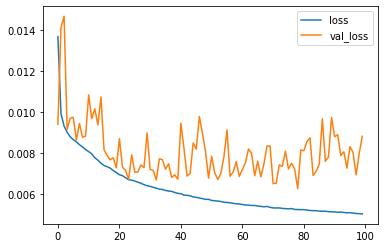

In [5]:
trainer.metrics[['loss', 'val_loss']].plot()

### Generator fine-tuning (GAN)
**Set parameters**

In [9]:
batch_size = 24
scaling_factor = 3

folder_path = '../../datasets/processed/Models/'
dataset_name = 'L8_S2_SR_x3'

**Read dataset**

In [10]:
TFRecord = datasets.read_TFRecords(folder_path, dataset_name,normalize_rgb = True, norm_range = [[0,1], [-1,1]],\
                                   batch_size=batch_size, shuffle_size=2000, scaling_factor=scaling_factor)

train_dataset = TFRecord.get_training_dataset()

batch_count = int(TFRecord.params['training_size'] / batch_size)
input_shape = (TFRecord.params['kernel_size']//scaling_factor, TFRecord.params['kernel_size']//scaling_factor, len(TFRecord.params['in_bands']))
output_shape = (TFRecord.params['kernel_size'], TFRecord.params['kernel_size'], len(TFRecord.params['out_bands']))

**Create models**

In [11]:
# Location of model weights
weights_dir = '../../datasets/processed/Models/L8_S2_SR_x3/srgan_generator_L8_to_S2_x3'
weights_file = lambda filename: os.path.join(weights_dir, filename)

generator = srgan.Generator(input_shape, scaling_factor).generator()
generator.load_weights(weights_file('model_weights.h5'))

discriminator = srgan.Discriminator(output_shape).discriminator()

**Create `trainer` object**

In [12]:
trainer = train_SR.SrganTrainer(folder_path, dataset_name, model_name = 'srgan_L8_to_S2_x3', generator=generator, discriminator=discriminator, content_loss='VGG22')

### Train model

--------------- Epoch 1 ---------------


100%|██████████| 2000/2000 [26:20<00:00,  1.27it/s]


Time for epoch 1 is 1580.1967561244965 sec
Epoch 1, perceptual loss = 0.0184, discriminator loss = 1.6352
--------------- Epoch 2 ---------------


100%|██████████| 2000/2000 [25:23<00:00,  1.31it/s]


Time for epoch 2 is 1523.8830134868622 sec
Epoch 2, perceptual loss = 0.0192, discriminator loss = 0.6815
--------------- Epoch 3 ---------------


100%|██████████| 2000/2000 [25:48<00:00,  1.29it/s]


Time for epoch 3 is 1548.6593992710114 sec
Epoch 3, perceptual loss = 0.0216, discriminator loss = 0.3507
--------------- Epoch 4 ---------------


100%|██████████| 2000/2000 [26:14<00:00,  1.27it/s]


Time for epoch 4 is 1574.0389006137848 sec
Epoch 4, perceptual loss = 0.0228, discriminator loss = 0.3803
--------------- Epoch 5 ---------------


100%|██████████| 2000/2000 [26:25<00:00,  1.26it/s]


Saving the checkpoints 
Time for epoch 5 is 1587.0952112674713 sec
Epoch 5, perceptual loss = 0.0197, discriminator loss = 0.4098
Saving the model


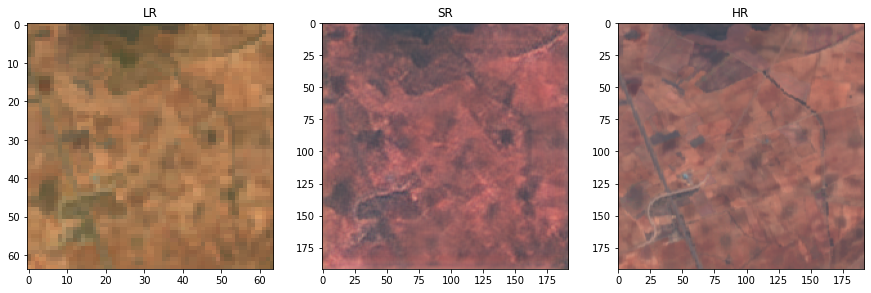

In [13]:
trainer.train(train_dataset, epochs=5, steps=batch_count)

### Inspect the training process
**Plot loss**

<AxesSubplot:>

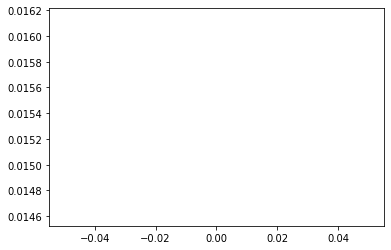

In [7]:
trainer.metrics['perceptual_loss'].plot()

<AxesSubplot:>

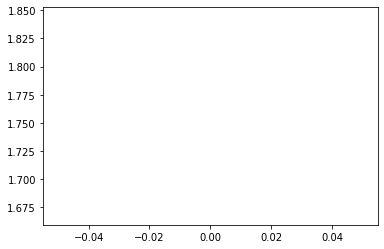

In [8]:
trainer.metrics['discrimination_loss'].plot()

## **Prediction**
**Create model**

In [3]:
# Location of model weights
weights_dir = '../../datasets/processed/Models/L8_S2_SR_x3/srgan_generator_L8_to_S2_x3'
weights_file = lambda filename: os.path.join(weights_dir, filename)

pre_generator = srgan.Generator(input_shape=(None, None, 3), scale=3).generator()
pre_generator.load_weights(weights_file('model_weights.h5'))

# Location of model weights
weights_dir = '../../datasets/processed/Models/L8_S2_SR_x3/srgan_L8_to_S2_x3'
weights_file = lambda filename: os.path.join(weights_dir, filename)

gan_generator = srgan.Generator(input_shape=(None, None, 3), scale=3).generator()
gan_generator.load_weights(weights_file('generator_weights.h5'))

**Create `Predictor` object**

In [4]:
predictor = predict_SR.Predictor(folder_path = '../../datasets/processed/Models/', dataset_name = 'L8_S2_SR_x3', models = [pre_generator])

**Select region**

In [5]:
predictor.select_region(lat=40.4394, lon=-3.6981, zoom=12)
predictor.map

Draw a rectangle on map to select and area.


Map(center=[40.4394, -3.6981], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

**Create input image**

In [6]:
predictor.create_input_image()

Url()

**Predict**

In [8]:
predictor.predict(norm_range=[[0,1], [-1,1]])

Url()

In [7]:
predictor.map

Map(bottom=395514.0, center=[40.4338305, -3.6954245], controls=(ZoomControl(options=['position', 'zoom_in_text…

**Plot**

Text(0.5, 1.0, 'SR (GAN)')

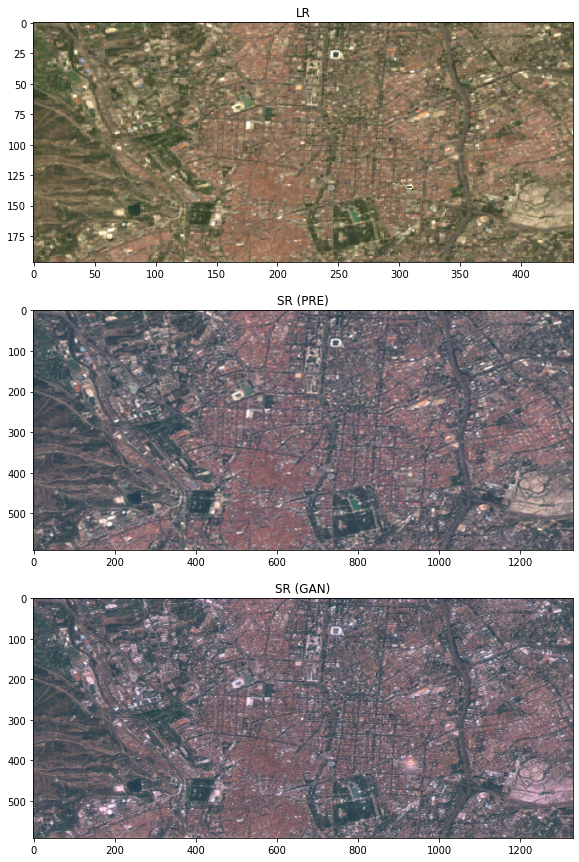

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(20,15))

ax[0].imshow(predictor.image[0,:,:,:3])
ax[0].set_title('LR')

ax[1].imshow(predictor.predictions[0][0,:,:,:3])
ax[1].set_title('SR (PRE)')

ax[2].imshow(predictor.predictions[1][0,:,:,:3])
ax[2].set_title('SR (GAN)')